# Initial Hamming Weight experiment

With brute-force hyper parameter optimization of the MLP.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.data.ascad import AscadRandomKey
from src.dlla.hw import NUM_CLASSES, fetch_traces, plot_predictions, dlla_hw, dlla_p_gradient, encode, split_traces
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.tools.cache import cache_np
from src.tools.lists import random_divide, randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, store_sns
from src.trace_set.database import Database
from src.trace_set.pollution import Pollution, PollutionType
from src.trace_set.set_hw import TraceSetHW
from src.trace_set.transform import reduce_fixed_fixed
from src.tvla.cri import tvla_cri, tvla_cri_p_gradient
from src.tvla.tvla import Tvla

init_plots()

In [2]:
DB = Database.ascad
TRACE_SET = TraceSetHW(DB)

In [3]:
def prepare_traces_dl(x, y, x_att, y_att):
    """
    Normalizes the traces, one-hot encodes the labels.
    Returns profiling traces, labels and attack traces, labels.
    """
    prof_mean, prof_std = x.mean(axis=0), x.std(axis=0)
    norm_x = (x - prof_mean) / prof_std
    norm_x_att = (x_att - prof_mean) / prof_std

    return norm_x, encode(y), norm_x_att, encode(y_att)

X, Y, X_ATT, Y_ATT = prepare_traces_dl(*TRACE_SET.profile(), *TRACE_SET.attack())

In [4]:
TRACE_LENGTH = X.shape[1]

### Model creation

With model hyper-parameters to be optimized.

In [5]:
def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(x.shape[1],)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [6]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [7]:
best_model = make_mlp(X, Y, X_ATT, Y_ATT, {
    'activation':'relu',
    'optimizer': Adam(learning_rate=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

0epoch [00:00, ?epoch/s]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [8]:
best_model.predict(X_ATT[:1])[0]

array([0.00244326, 0.0300958 , 0.10031179, 0.20051192, 0.2563607 ,
       0.23169586, 0.12558031, 0.04702367, 0.0059767 ], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [9]:
np.sum(best_model.predict(X_ATT[:1])[0] * range(8 + 1))

4.146638372913003

In [10]:
dlla_hw(best_model, X_ATT, Y_ATT)

0.0

### Plot prediction distribution for all traces.

In [11]:
# store_sns(plot_predictions(best_model, X_ATT, Y_ATT), "dlla-9-predictions")

### Plot p-gradient.

In [12]:
A_ATT, B_ATT = split_traces(X_ATT, Y_ATT, balance=True)

In [13]:
MAX_LEN = round(len(A_ATT) / 2)
TVLA_AB = Tvla(A_ATT.shape[1])
TVLA_AB.add(A_ATT[:MAX_LEN], B_ATT)
TVLA_BB = Tvla(TRACE_LENGTH)
TVLA_BB.add(*random_divide(B_ATT))

Computing min-p gradients: 100%|██████████| 3/3 [01:08<00:00, 22.84s/it]


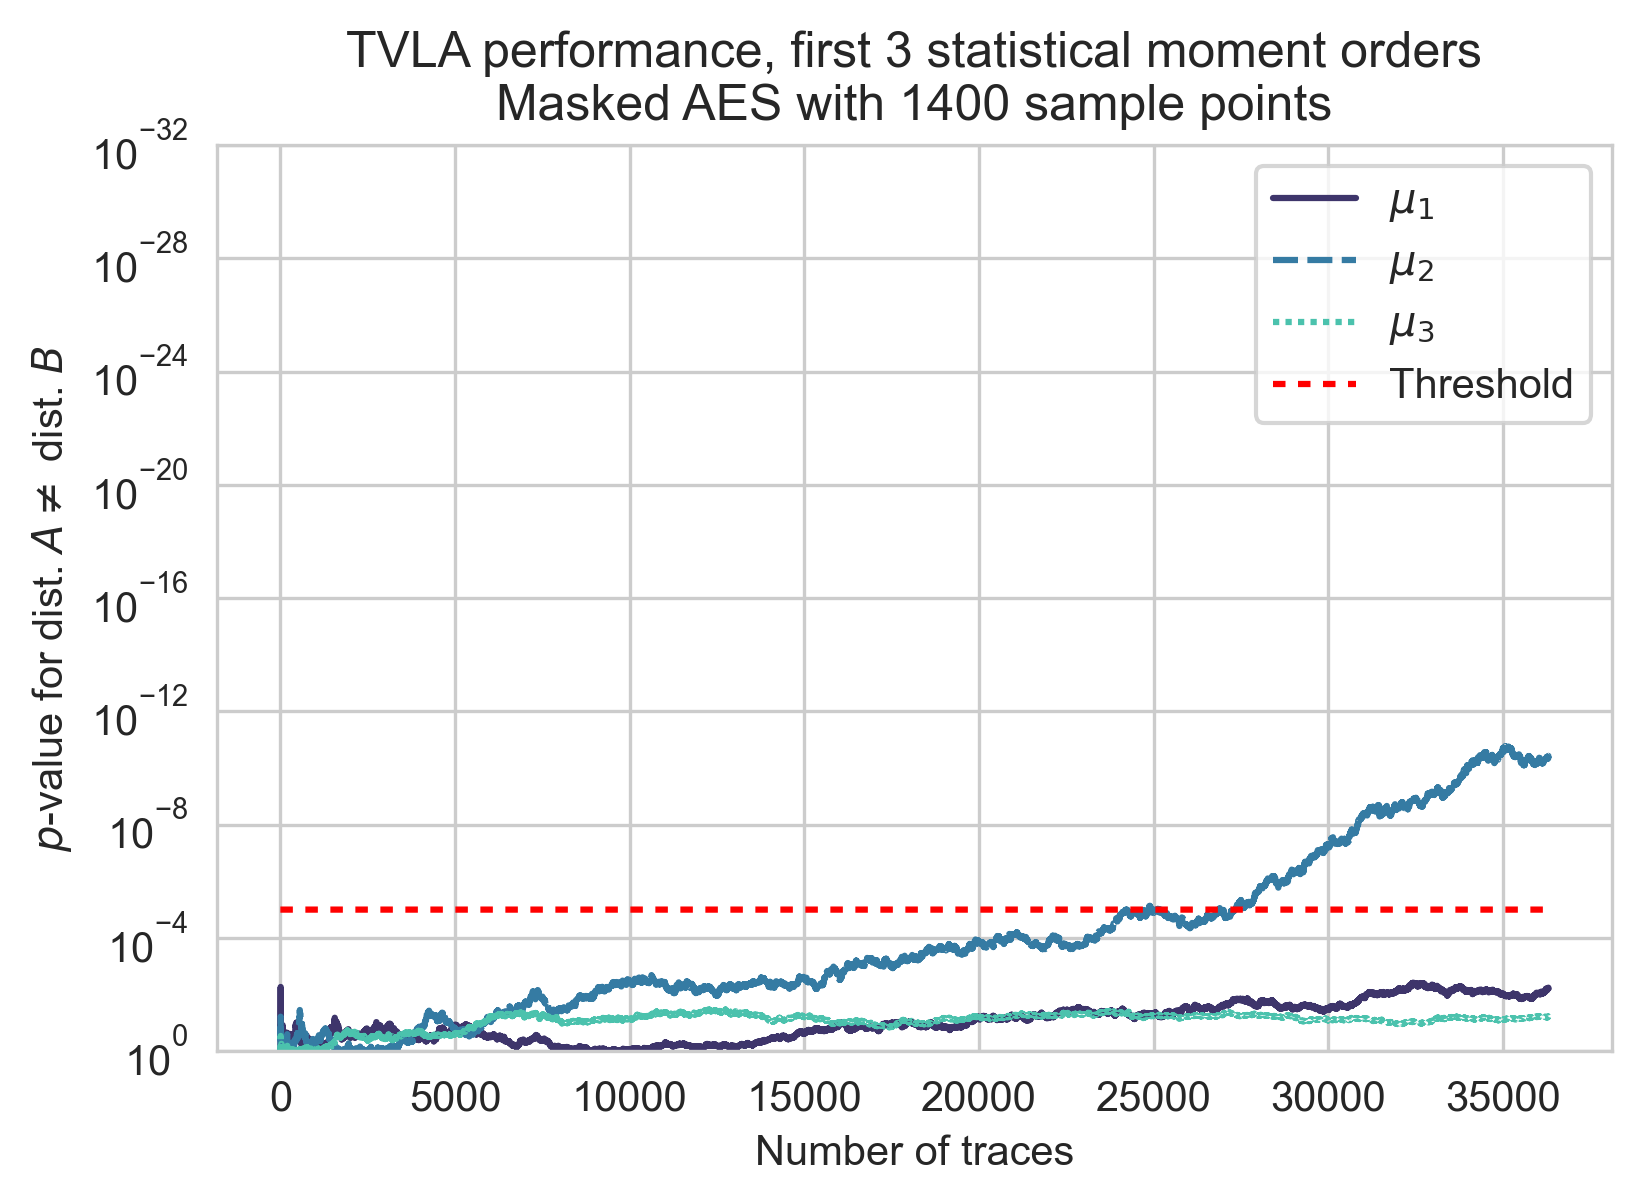

In [14]:
plot_p_gradient(dict([(f"$\\mu_{{{d}}}$", TVLA_AB.p_gradient(d)) for d in range(1, 4)]),
                "TVLA performance, first 3 statistical moment orders\nMasked AES with 1400 sample points", palette=PALETTE_GRADIENT)

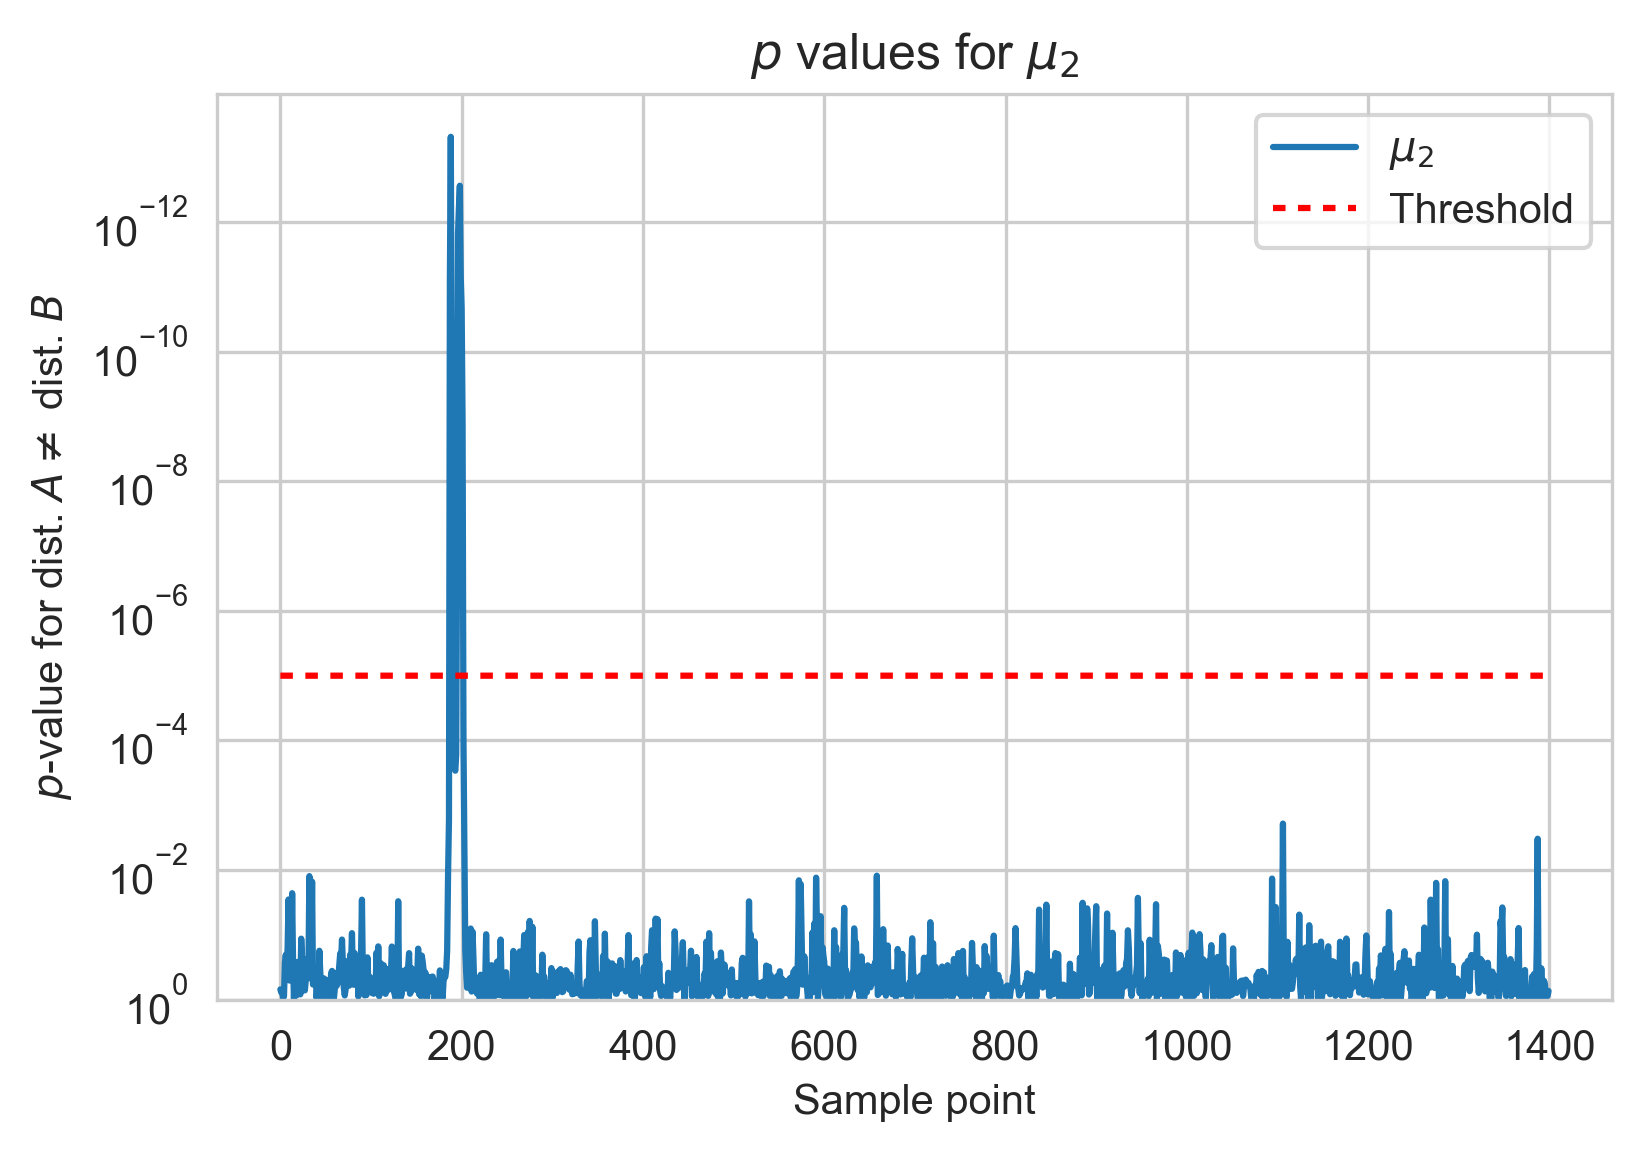

In [15]:
G = TVLA_AB.plot_p_values(2)
store_sns(G, "p-values-ascad")

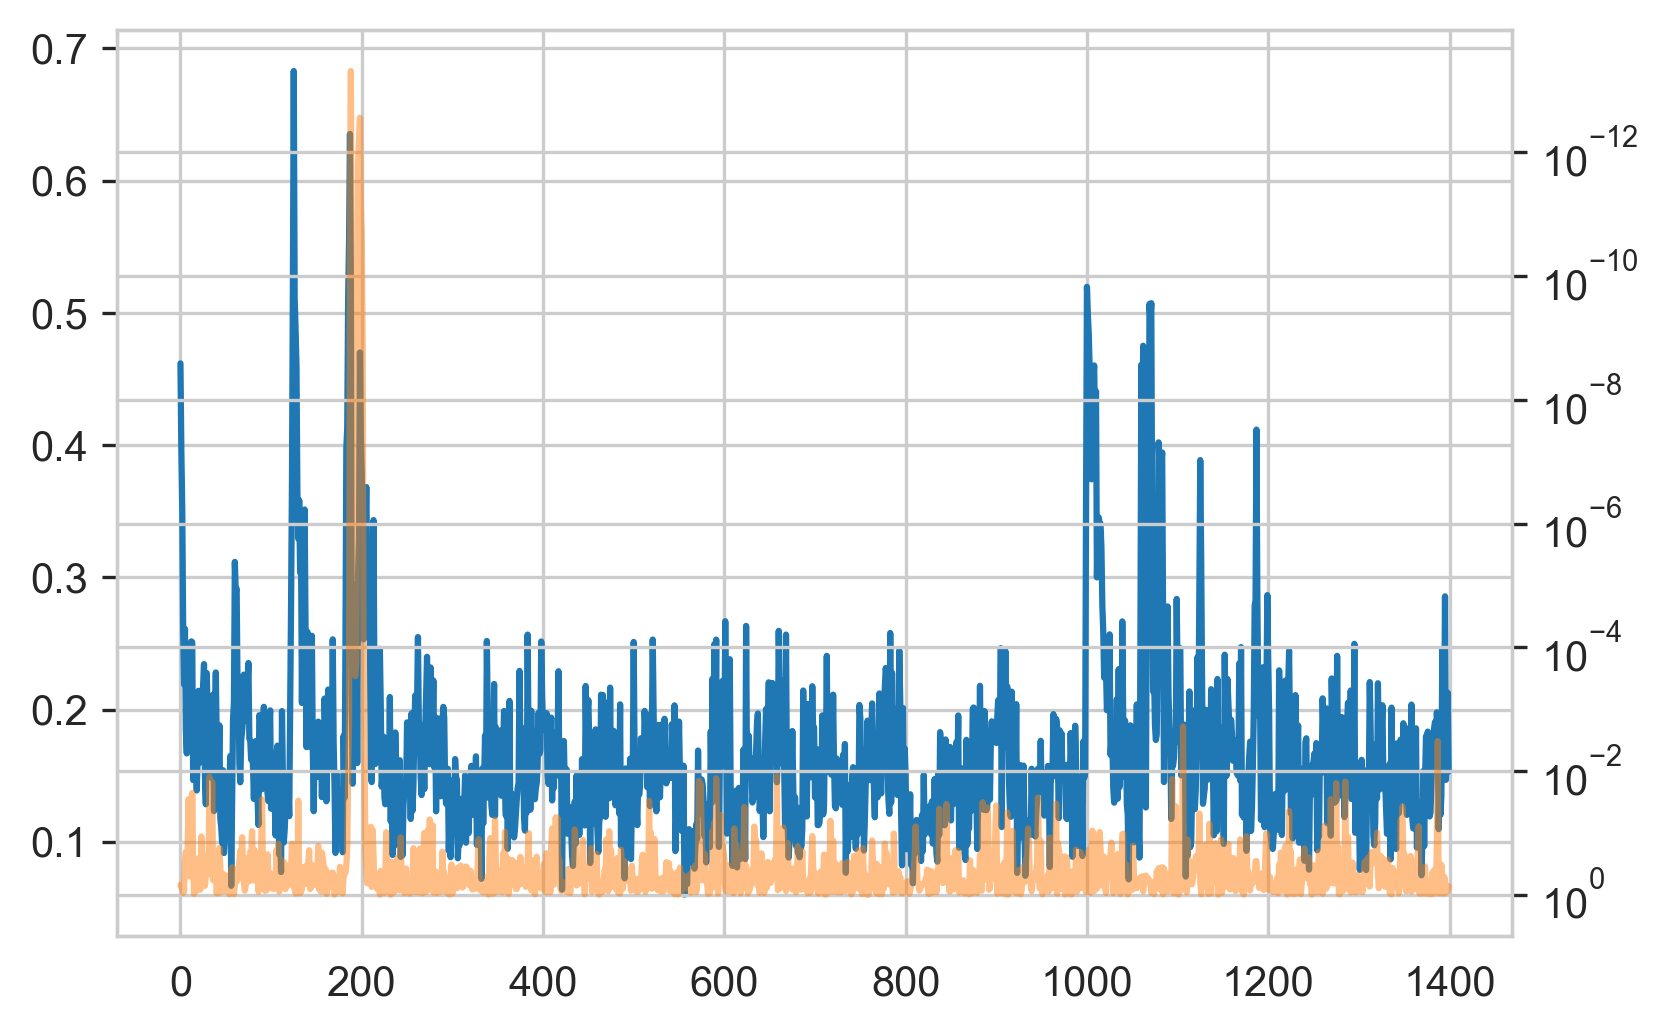

In [16]:
MAX_WEIGHTS = np.max(best_model.layers[0].get_weights()[0], axis=1)

sns.lineplot(data=MAX_WEIGHTS)
AX2 = plt.twinx()
G = sns.lineplot(data=TVLA_AB.min_p[2], ax=AX2, color=sns.color_palette()[1], alpha=.5)
G.set(yscale="log")
G.invert_yaxis()

In [17]:
print("p-value for uncorrelated system producing these datasets")
pearsonr(MAX_WEIGHTS, TVLA_AB.min_p[2])[1]

p-value for uncorrelated system producing these datasets


0.00043428801183501237

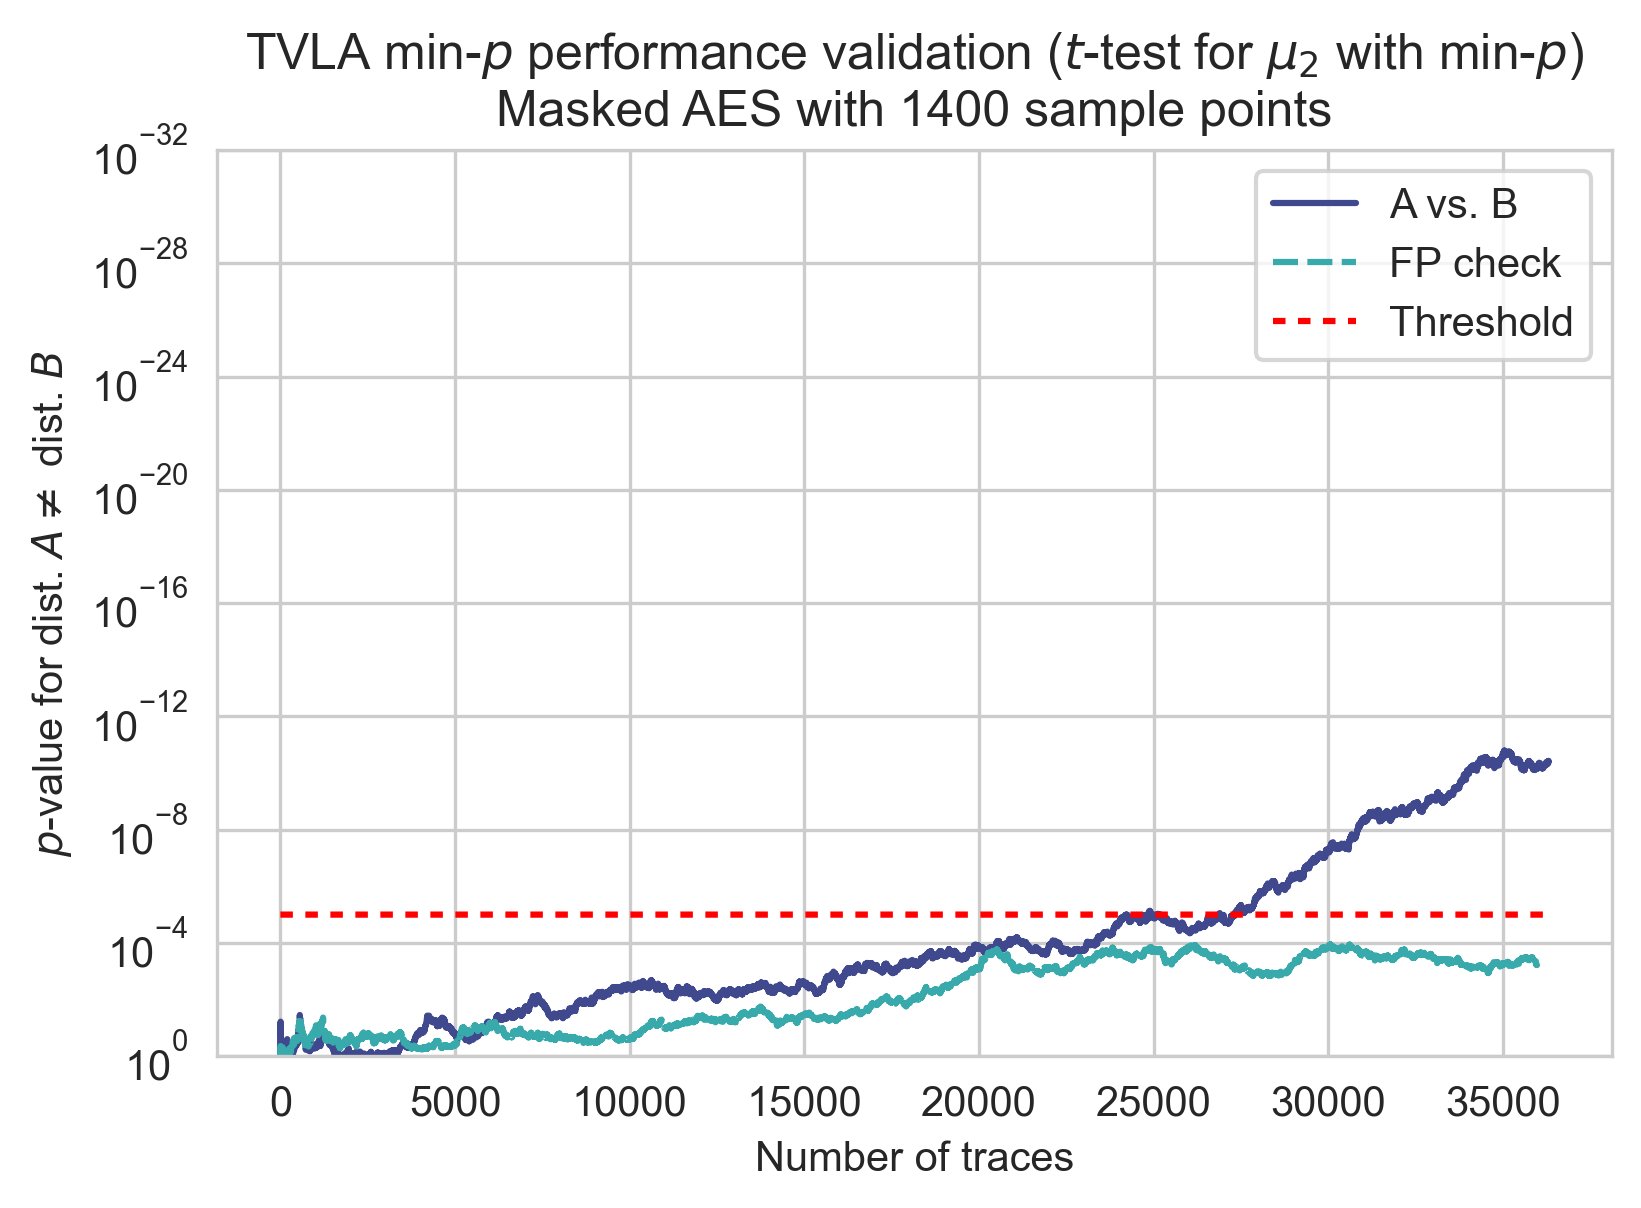

In [18]:
plot_p_gradient({
    "A vs. B": TVLA_AB.p_gradient(2),
    "FP check": TVLA_BB.p_gradient(2)
}, "TVLA min-$p$ performance validation ($t$-test for $\\mu_2$ with min-$p$)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="tvla-validation-mu2")

PG_LEN = len(TVLA_AB.p_gradient(2))

In [19]:
CRI_AB = cache_np("cri_tvla_pg_ab", tvla_cri_p_gradient, TRACE_SET, 2, False, None, 1)
CRI_RANDOM = cache_np("cri_tvla_pg_random", tvla_cri_p_gradient, TRACE_SET, 2, True, None, 1)

In [20]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

NUM_TRACES = len(X)
PG_CRI_AB = np.interp(range(NUM_TRACES), moving_average(CRI_AB[0], 5), moving_average(CRI_AB[1], 5))
PG_CRI_RANDOM = np.interp(range(NUM_TRACES), moving_average(CRI_RANDOM[0], 5), moving_average(CRI_RANDOM[1], 5))

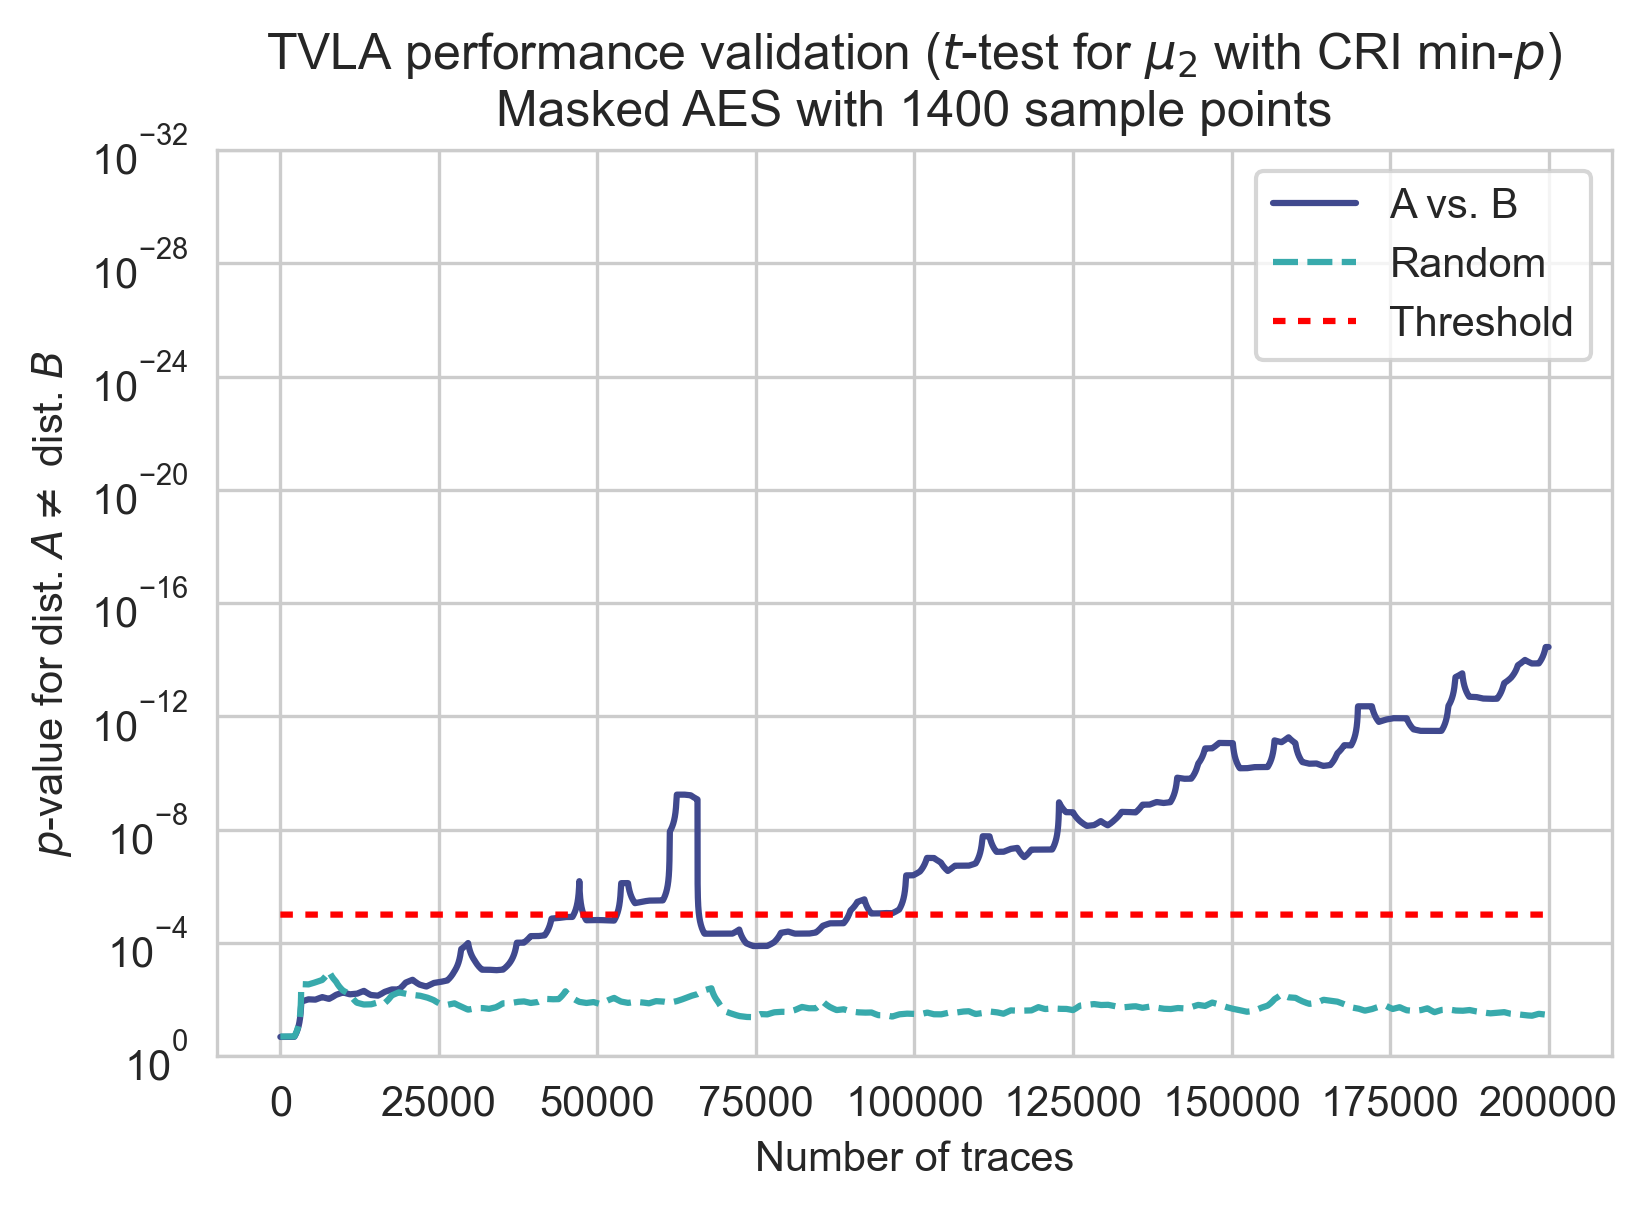

In [21]:
# PG_CRI_RANDOM = np.interp(range(NUM_TRACES), CRI_RANDOM[0], CRI_RANDOM[1])

plot_p_gradient({
    "A vs. B": PG_CRI_AB,
    "Random": PG_CRI_RANDOM,
}, "TVLA performance validation ($t$-test for $\\mu_2$ with CRI min-$p$)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="tvla-cri-validation-mu2")

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


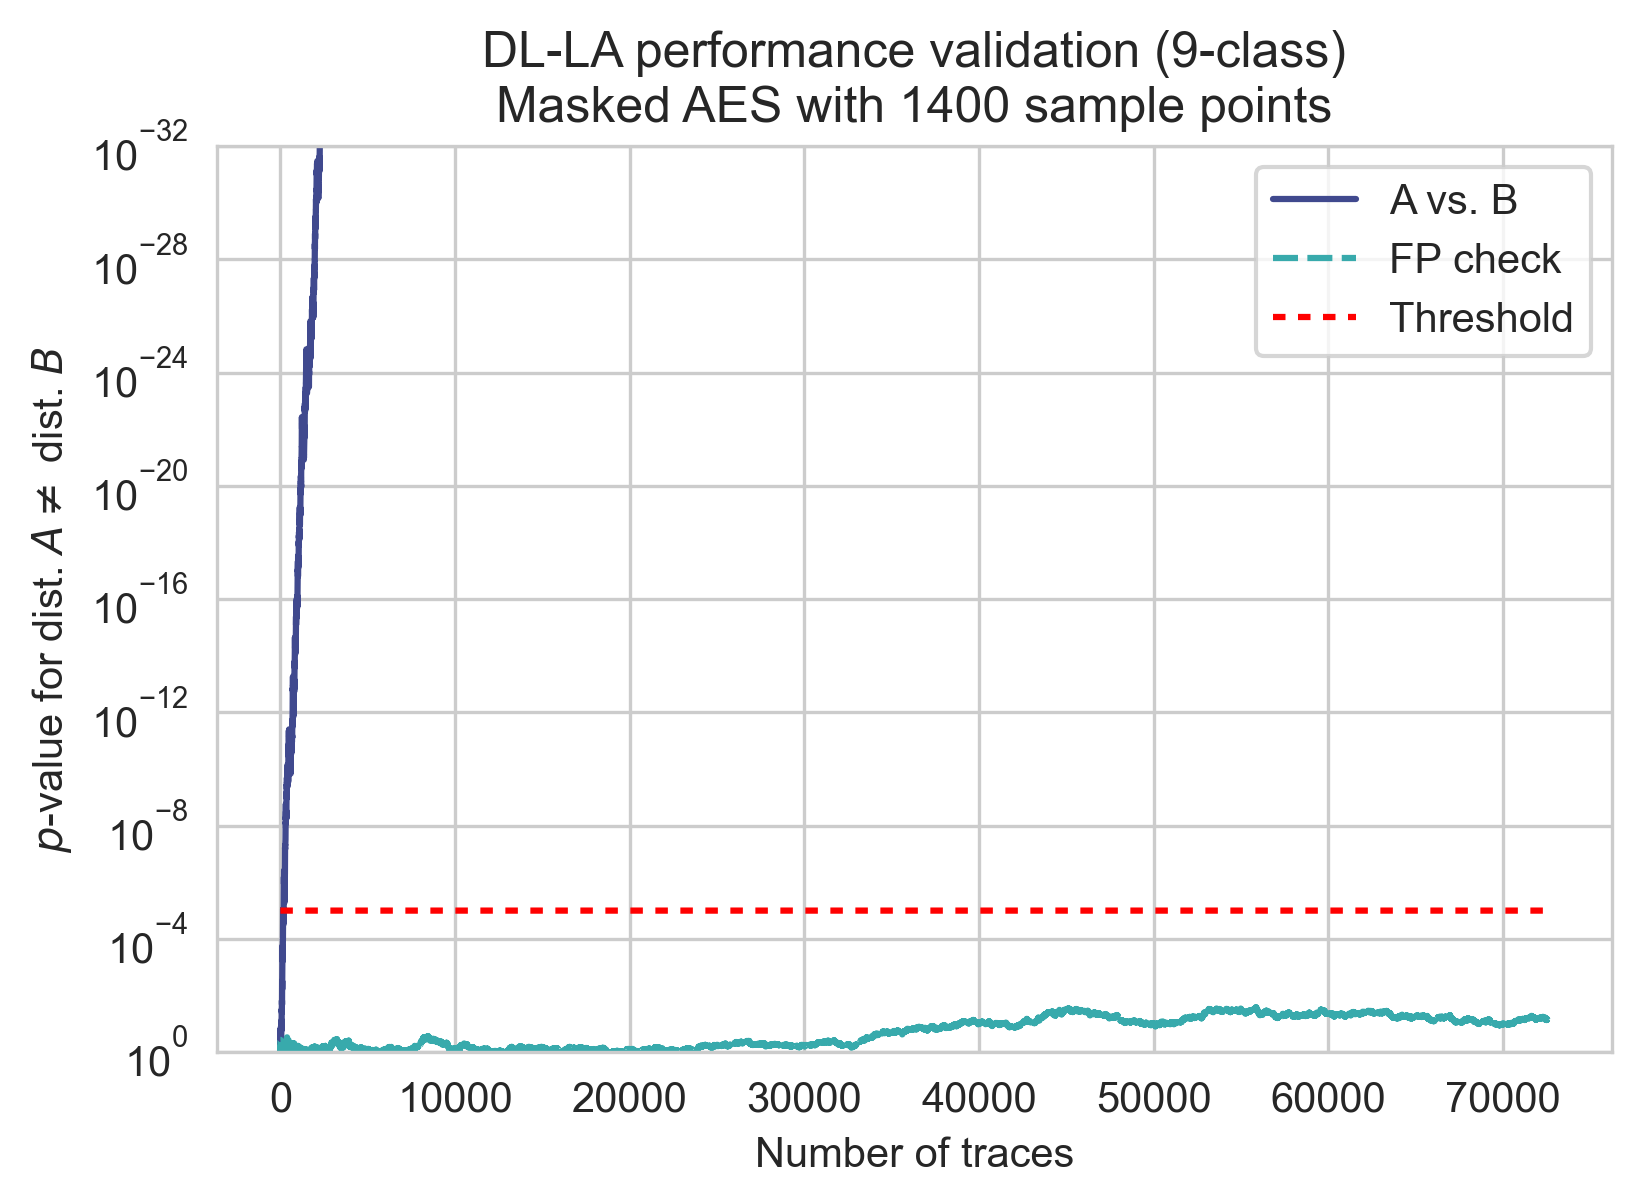

In [23]:
PG_DLLA_9 = dlla_p_gradient(best_model, X_ATT, Y_ATT)
PG_DLLA_9_RANDOM = dlla_p_gradient(best_model, X_ATT, randomize(Y_ATT))

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "FP check": np.array(PG_DLLA_9_RANDOM),
}, "DL-LA performance validation (9-class)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="dlla-9-validation"
)

In [24]:
X_PROF_2, Y_PROF_2 = reduce_fixed_fixed(X, Y)
X_ATT_2, Y_ATT_2 = reduce_fixed_fixed(X_ATT, Y_ATT)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

Epoch 1/5
969/969 [==============================] - 2s 2ms/step - loss: 0.2491 - accuracy: 0.5337

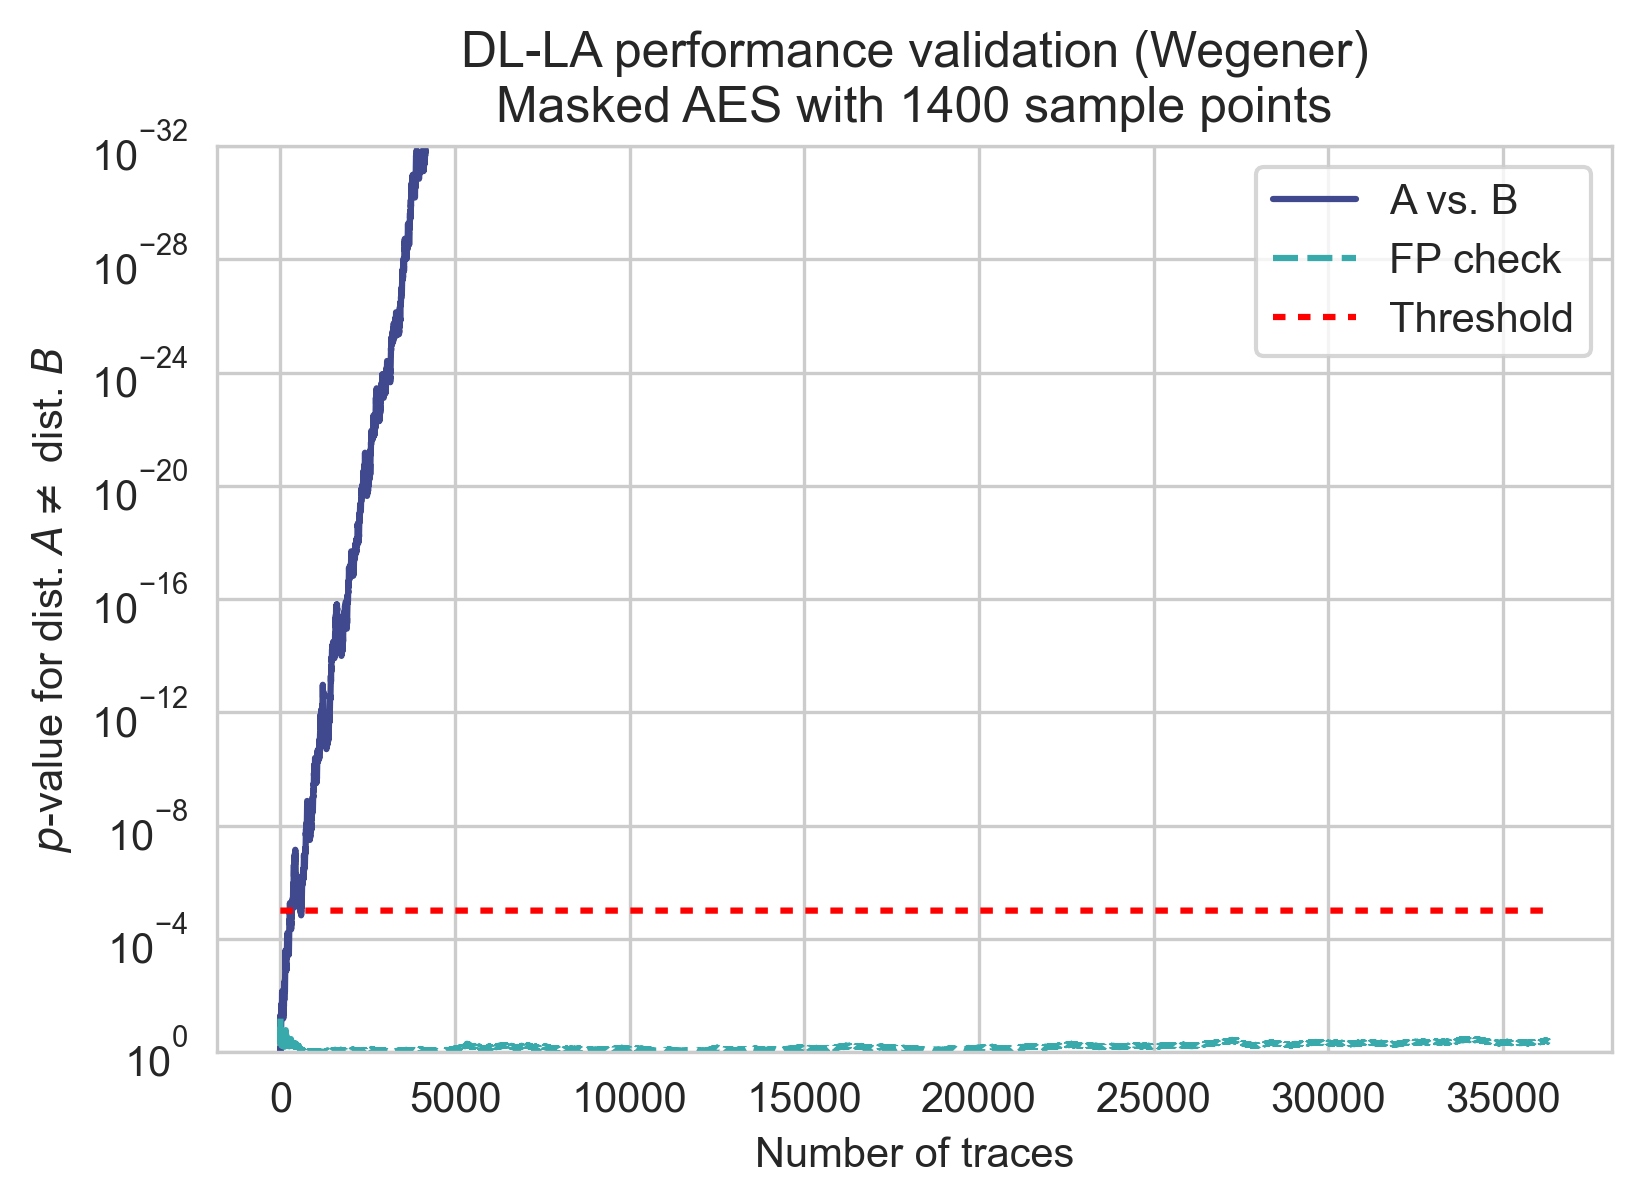

In [25]:
MODEL_WEGENER_AB = make_mlp_wegener(X_PROF_2, Y_PROF_2)

PG_DLLA_2_AB = wegener_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2[:PG_LEN])
PG_DLLA_2_RANDOM =  wegener_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2_RANDOM[:PG_LEN])

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "FP check": np.array(PG_DLLA_2_RANDOM),
}, "DL-LA performance validation (Wegener)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="dlla-2-validation"
)

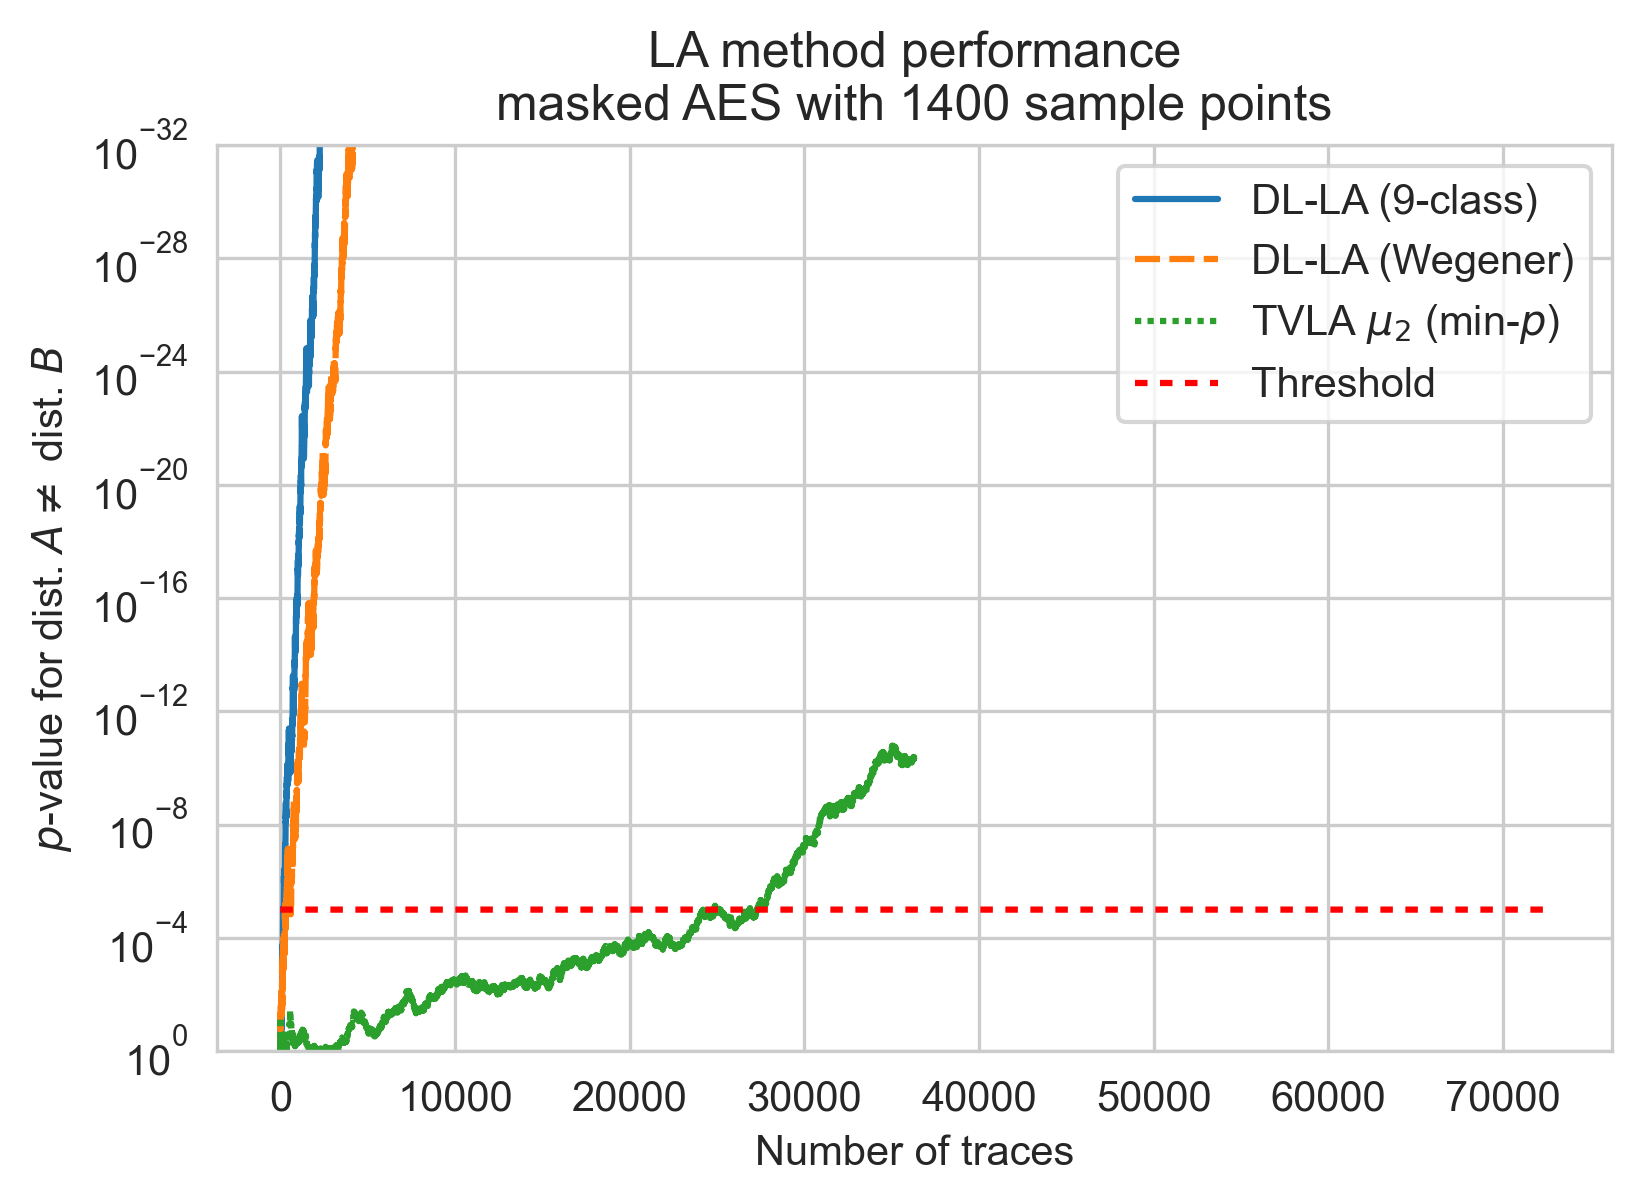

In [26]:
plot_p_gradient({
    "DL-LA (9-class)": np.array(PG_DLLA_9),
    "DL-LA (Wegener)": np.array(PG_DLLA_2_AB),
    "TVLA $\\mu_2$ (min-$p$)": TVLA_AB.p_gradient(2)
},"LA method performance\nmasked AES with 1400 sample points",
    file_name="ascad-default-all"
)

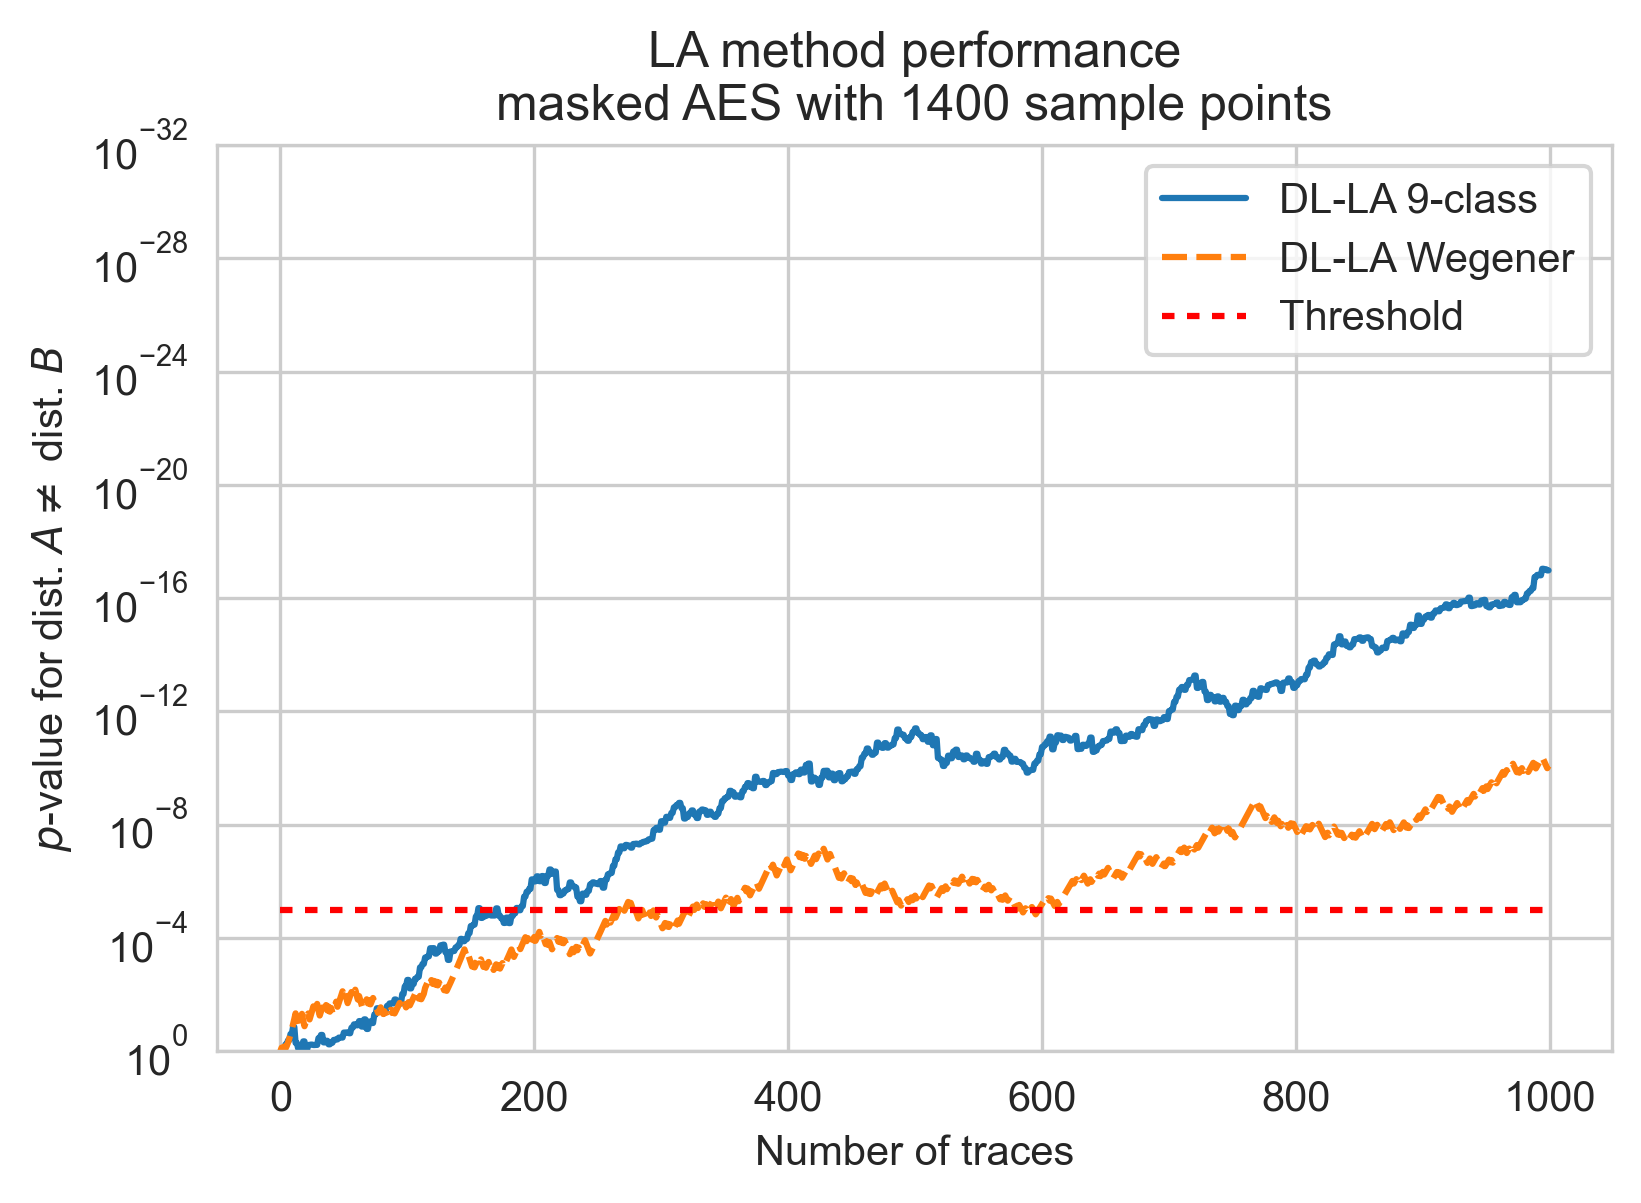

In [28]:
PGS = {
    "DL-LA 9-class": np.array(PG_DLLA_9)[:1000],
    "DL-LA Wegener": np.array(PG_DLLA_2_AB[:1000]),
}

DF = pd.DataFrame(PGS)
DF.to_csv("dlla-p-gradient.csv")
plot_p_gradient(PGS, "LA method performance\nmasked AES with 1400 sample points",
    file_name="ascad-default-dlla-1000"
)
